In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import random
import time

start = time.process_time()

In [2]:
# defining constants

alpha = 0.4 

sweeps = 20000 # the amount of times we update the M-H path (should change)
tau = 250 # imaginary time, need to change tau 
dtau = 1 # time step
eta = dtau
ntau = int(tau / dtau) # number of time steps 
hitsize = 0.1 # need to test

xlow = - 4 # min x value
xhigh = 4 # max x value
n_xbins = 100 # number of x steps
dx = (xhigh - xlow) / n_xbins # size of x step
x_bins = np.linspace(xlow, xhigh, n_xbins + 1) # x steps

x_path = np.zeros(ntau)

what tau_b do we need theoretically to arrive at ground state --
and tune delta tau 

beta = 1/(k_b)t  thermal energy 

we want to solve for the maxwells dist. 

want kbt to be significantly less than the ground state energy 


In [3]:
def potential(x):
    
    """
    Defining the potential at some point x
    x: the value at which to determine the potential
    Returns: the double well potential, at that point
    """
    return (alpha * x ** 4) - (2 * x ** 2) + (1 / alpha)

def vary_path(x_current, hitsize):
    
    """
    Picking a random point in the domain.
    x_current: the current point in the x-domain
    Returns: a new point, randomly picked
    """
    x_prime = x_current + np.random.random() * 2 * hitsize - hitsize
    
    while x_prime > xhigh or x_prime < xlow:
        x_prime = x_current + np.random.random() * 2 * hitsize - hitsize
        
    return x_prime

# here I defined the action based on the lagrangian in the final project. 
# this is the exponential portion of eq 3 and 4
def action(x_left, x_right):
    """
    Determining the action from a left and right point.
    x_left: the left limit of the action potential
    x_right: the right limit of the action potential
    Returns: the action
    """
    k = 0.5 * (((x_right - x_left)) ** 2) / dtau
    v = dtau * potential(((x_left + x_right) / 2))
    return k + v

# action S is the integral of the lagrangian. So that is why this can be K + V instead of K - V 
# not used as of right now
def total_action(x_path):
    """
    Determining the total action across some point.
    x_path: the path across which to determine the action
    Returns: the total action
    """
    path_action = 0
    
    for i in range(-1, n_xbins - 1):
        path_action += action(x_path[i], x_path[i + 1])
        
    return path_action

def delta_action(x_path, prime, i):
    """
    Determining the difference in action across some point and in comparison to another point.
    x_path: the path across which to determine the action
    prime: the other point to compare the action to
    i: the index of the point to compare actions across
    Returns: the total action
    """
    left = x_path[i - 1]
    right = x_path[i + 1] if i < ntau - 1 else x_path[0] 
    daction = action(left, prime) + action(prime, right) - (action(left, x_path[i]) + action(x_path[i], right))

    return daction

In [4]:
def mcmc(x_path, mean_energies, prob_histogram, n_accept, tau=250, dtau=1, hitsize=0.1, thinning_val=1): 
    """
    Applying MCMC algorithm to path to find ground state energy, proportional to x^2
    
    x_path: the path across which to apply the MCMC algorithm
    mean_energies: array to save energy values to
    prob_histogram: array to save probability values to
    n_accept: number of accepted values
    tau: imaginary time for algorithm to run across 
    dtau: step size for tau
    hitsize: random interval size to generate value from
    thinning_val: value used to consider for thinning the algorithm, default one
    
    Return: number of accepted values
    """
    ntau = len(x_path)
    
    for i in range(0, ntau, thinning_val):
        
        if i == 0:
            x_prime = vary_path(x_path[i+1], hitsize)
        elif i == ntau - 1:
            x_prime = vary_path(x_path[i-1], hitsize)
        else:
            x_prime = vary_path(x_path[i], hitsize)
            
        daction = delta_action(x_path, x_prime, i)
        
        if daction <= 0: 
            x_path[i] = x_prime
            n_accept += 1
            
        else:     
            prob = np.exp(- daction)
            if np.random.random() < prob:
                x_path[i] = x_prime
                n_accept += 1
                
    mean_energies.append(np.mean([i ** 2 for i in x_path]))
    
    hist, _ = np.histogram(x_path, bins=x_bins)
    prob_histogram += hist
    return n_accept

In [5]:
# initialize lists to store results for each combination of parameters
all_mean_energies = []
all_prob_histograms = []

sweep_values = [10000, 20000, 30000]  
hitsize_values = [0.05, 0.1, 0.2]  
dtau_values = [0.5, 1, 2]  

for sweeps_val in sweep_values:
    for hitsize_val in hitsize_values:
        for dtau_val in dtau_values:
            start = time.process_time()

            mean_energies = []
            prob_histogram = np.zeros(n_xbins)
            n_accept = 0

            for i in tqdm.tqdm(range(sweeps_val)):
                n_accept = mcmc(x_path, mean_energies, prob_histogram, n_accept, hitsize=hitsize_val, dtau=dtau_val)

            acceptance_rate = n_accept / (sweeps_val * ntau)
            print(f"Sweeps: {sweeps_val}, Hitsize: {hitsize_val}, dtau: {dtau_val}, Acceptance Rate: {acceptance_rate}")
            print(f"Elapsed Time: {(time.process_time() - start) / 60} minutes")

            # store mean energies and probability histograms for each combination
            all_mean_energies.append(mean_energies)
            all_prob_histograms.append(prob_histogram)

100%|██████████| 10000/10000 [00:35<00:00, 284.19it/s]


Sweeps: 10000, Hitsize: 0.05, dtau: 0.5, Acceptance Rate: 0.9797204
Elapsed Time: 0.5937582838 minutes


100%|██████████| 10000/10000 [00:35<00:00, 281.89it/s]


Sweeps: 10000, Hitsize: 0.05, dtau: 1, Acceptance Rate: 0.9778632
Elapsed Time: 0.5978976160999999 minutes


100%|██████████| 10000/10000 [00:34<00:00, 290.38it/s]


Sweeps: 10000, Hitsize: 0.05, dtau: 2, Acceptance Rate: 0.977732
Elapsed Time: 0.5817301483333334 minutes


100%|██████████| 10000/10000 [00:34<00:00, 290.14it/s]


Sweeps: 10000, Hitsize: 0.1, dtau: 0.5, Acceptance Rate: 0.9547412
Elapsed Time: 0.5825718479166665 minutes


100%|██████████| 10000/10000 [00:35<00:00, 278.66it/s]


Sweeps: 10000, Hitsize: 0.1, dtau: 1, Acceptance Rate: 0.9544264
Elapsed Time: 0.6051241804833334 minutes


100%|██████████| 10000/10000 [00:33<00:00, 295.87it/s]


Sweeps: 10000, Hitsize: 0.1, dtau: 2, Acceptance Rate: 0.9542716
Elapsed Time: 0.5709394572999997 minutes


100%|██████████| 10000/10000 [00:33<00:00, 295.46it/s]


Sweeps: 10000, Hitsize: 0.2, dtau: 0.5, Acceptance Rate: 0.9086072
Elapsed Time: 0.5715928588166667 minutes


100%|██████████| 10000/10000 [00:34<00:00, 292.60it/s]


Sweeps: 10000, Hitsize: 0.2, dtau: 1, Acceptance Rate: 0.9080868
Elapsed Time: 0.5767088397833333 minutes


100%|██████████| 10000/10000 [00:33<00:00, 295.55it/s]


Sweeps: 10000, Hitsize: 0.2, dtau: 2, Acceptance Rate: 0.9074456
Elapsed Time: 0.5705412706666664 minutes


100%|██████████| 20000/20000 [01:11<00:00, 277.95it/s]


Sweeps: 20000, Hitsize: 0.05, dtau: 0.5, Acceptance Rate: 0.9768424
Elapsed Time: 1.2124248943499993 minutes


100%|██████████| 20000/20000 [01:09<00:00, 286.31it/s]


Sweeps: 20000, Hitsize: 0.05, dtau: 1, Acceptance Rate: 0.9769236
Elapsed Time: 1.1785520969999994 minutes


100%|██████████| 20000/20000 [01:10<00:00, 283.63it/s]


Sweeps: 20000, Hitsize: 0.05, dtau: 2, Acceptance Rate: 0.9767346
Elapsed Time: 1.1902369151499992 minutes


100%|██████████| 20000/20000 [01:06<00:00, 299.63it/s]


Sweeps: 20000, Hitsize: 0.1, dtau: 0.5, Acceptance Rate: 0.953402
Elapsed Time: 1.1285007406333325 minutes


100%|██████████| 20000/20000 [01:05<00:00, 306.05it/s]


Sweeps: 20000, Hitsize: 0.1, dtau: 1, Acceptance Rate: 0.9534264
Elapsed Time: 1.1043555523833333 minutes


100%|██████████| 20000/20000 [01:06<00:00, 298.60it/s]


Sweeps: 20000, Hitsize: 0.1, dtau: 2, Acceptance Rate: 0.9535392
Elapsed Time: 1.130399880150001 minutes


100%|██████████| 20000/20000 [01:06<00:00, 302.22it/s]


Sweeps: 20000, Hitsize: 0.2, dtau: 0.5, Acceptance Rate: 0.9076002
Elapsed Time: 1.1198485737 minutes


100%|██████████| 20000/20000 [01:03<00:00, 314.30it/s]


Sweeps: 20000, Hitsize: 0.2, dtau: 1, Acceptance Rate: 0.9077268
Elapsed Time: 1.0772461155500006 minutes


100%|██████████| 20000/20000 [01:05<00:00, 306.47it/s]


Sweeps: 20000, Hitsize: 0.2, dtau: 2, Acceptance Rate: 0.9072888
Elapsed Time: 1.1004974184833334 minutes


100%|██████████| 30000/30000 [01:39<00:00, 300.50it/s]


Sweeps: 30000, Hitsize: 0.05, dtau: 0.5, Acceptance Rate: 0.9765565333333334
Elapsed Time: 1.6848002722500022 minutes


100%|██████████| 30000/30000 [01:36<00:00, 309.67it/s]


Sweeps: 30000, Hitsize: 0.05, dtau: 1, Acceptance Rate: 0.9763869333333334
Elapsed Time: 1.6401674059333307 minutes


100%|██████████| 30000/30000 [01:37<00:00, 307.72it/s]


Sweeps: 30000, Hitsize: 0.05, dtau: 2, Acceptance Rate: 0.9765512
Elapsed Time: 1.6509818138333305 minutes


100%|██████████| 30000/30000 [01:36<00:00, 309.61it/s]


Sweeps: 30000, Hitsize: 0.1, dtau: 0.5, Acceptance Rate: 0.9530098666666666
Elapsed Time: 1.6396506664166661 minutes


100%|██████████| 30000/30000 [01:35<00:00, 315.34it/s]


Sweeps: 30000, Hitsize: 0.1, dtau: 1, Acceptance Rate: 0.9531069333333333
Elapsed Time: 1.6099640773333326 minutes


100%|██████████| 30000/30000 [01:35<00:00, 314.61it/s]


Sweeps: 30000, Hitsize: 0.1, dtau: 2, Acceptance Rate: 0.9535514666666667
Elapsed Time: 1.6159166263833338 minutes


100%|██████████| 30000/30000 [01:36<00:00, 309.98it/s]


Sweeps: 30000, Hitsize: 0.2, dtau: 0.5, Acceptance Rate: 0.9070956
Elapsed Time: 1.639979808333332 minutes


100%|██████████| 30000/30000 [01:36<00:00, 311.61it/s]


Sweeps: 30000, Hitsize: 0.2, dtau: 1, Acceptance Rate: 0.9067388
Elapsed Time: 1.629689321733334 minutes


100%|██████████| 30000/30000 [01:36<00:00, 310.23it/s]

Sweeps: 30000, Hitsize: 0.2, dtau: 2, Acceptance Rate: 0.9068048
Elapsed Time: 1.6357128938166663 minutes


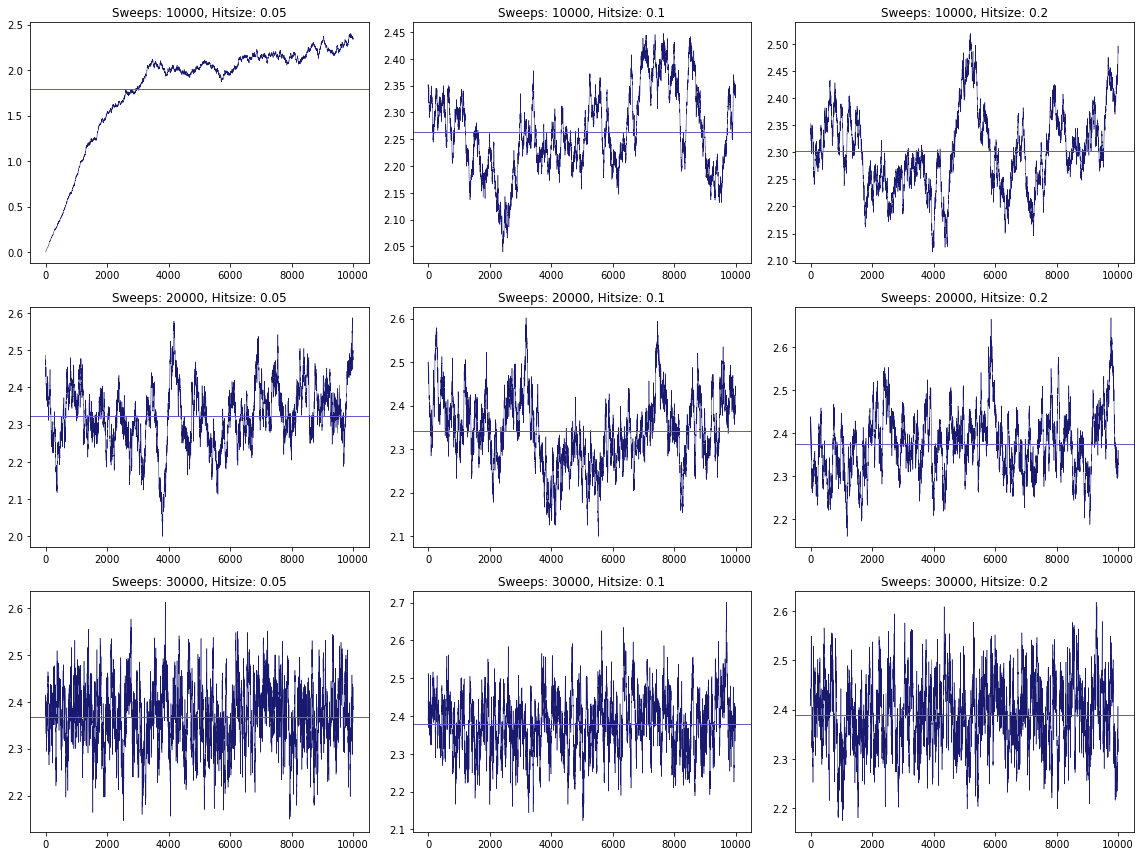

In [6]:
# plot results for each combination of parameters
fig, axs = plt.subplots(len(sweep_values), len(hitsize_values), figsize=(16, 12))

for i, sweeps_val in enumerate(sweep_values):
    for j, hitsize_val in enumerate(hitsize_values):
        idx = i * len(hitsize_values) + j
        axs[i, j].plot(range(len(all_mean_energies[idx])), all_mean_energies[idx], lw=0.5, color='midnightblue')
        axs[i, j].axhline(np.mean(all_mean_energies[idx]), lw=1, color='slateblue',
                          label='Mean of means = {}'.format(np.mean(all_mean_energies[idx])))
        axs[i, j].set_title(f"Sweeps: {sweeps_val}, Hitsize: {hitsize_val}")

plt.tight_layout()
plt.show()

In [13]:
# define a plotting function for mean energies
def plot_mean_energies(all_mean_energies, sweep_values, hitsize_values):
    fig, axs_mean = plt.subplots(len(sweep_values), len(hitsize_values), figsize=(16, 12))
    
    for i, sweeps_val in enumerate(sweep_values):
        for j, hitsize_val in enumerate(hitsize_values):
            idx = i * len(hitsize_values) + j
            axs_mean[i, j].plot(range(len(all_mean_energies[idx])), all_mean_energies[idx], lw=0.5, color='midnightblue')
            axs_mean[i, j].axhline(np.mean(all_mean_energies[idx]), lw=1, color='slateblue',
                                   label='Mean of means = {}'.format(np.mean(all_mean_energies[idx])))
            axs_mean[i, j].set_title(f"Sweeps: {sweeps_val}, Hitsize: {hitsize_val}")

    plt.tight_layout()
    plt.show()

# define a plotting function for probability histograms
def plot_prob_histograms(all_prob_histograms, sweep_values, hitsize_values):
    fig, axs_hist = plt.subplots(len(sweep_values), len(hitsize_values), figsize=(16, 12))
    
    for i, sweeps_val in enumerate(sweep_values):
        for j, hitsize_val in enumerate(hitsize_values):
            idx = i * len(hitsize_values) + j
            axs_hist[i, j].stairs(all_prob_histograms[idx] / np.sum(all_prob_histograms[idx] * dx), x_bins, color='plum')
            axs_hist[i, j].set_title(f"Sweeps: {sweeps_val}, Hitsize: {hitsize_val}")

    plt.tight_layout()
    plt.show()

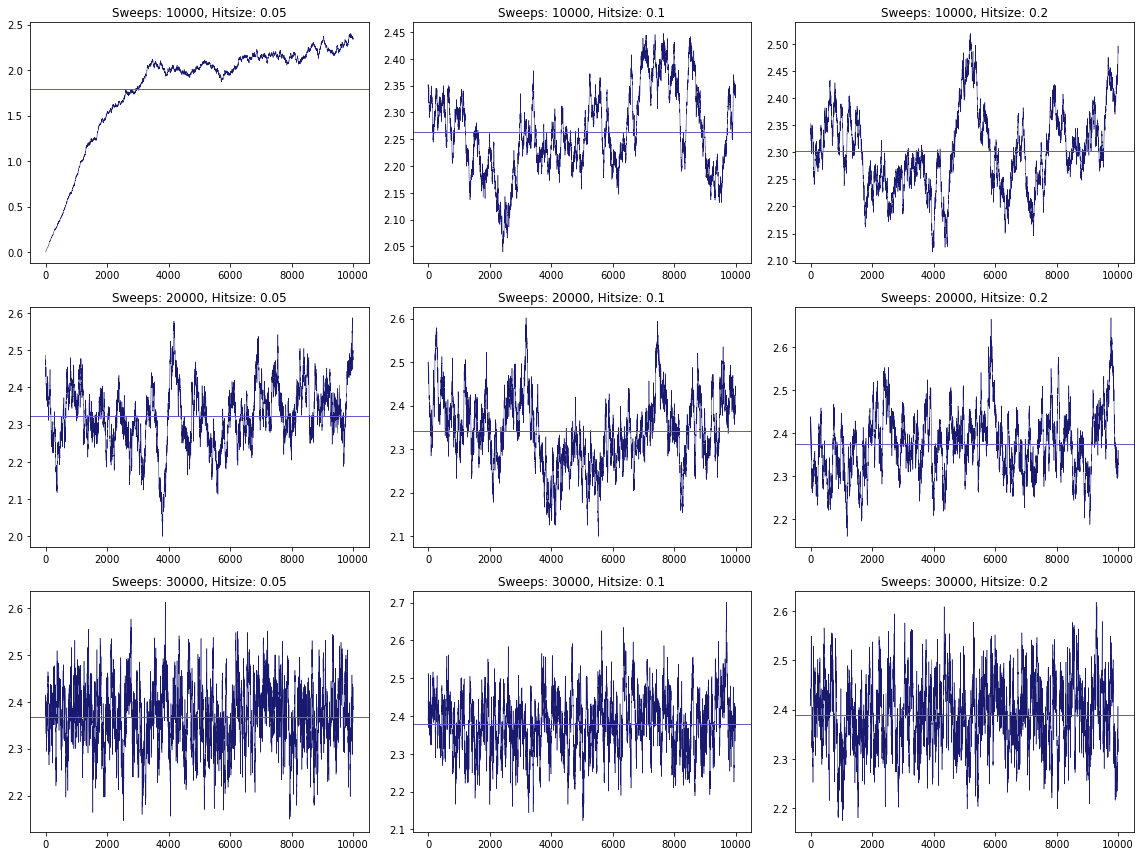

In [14]:
plot_mean_energies(all_mean_energies, sweep_values, hitsize_values)

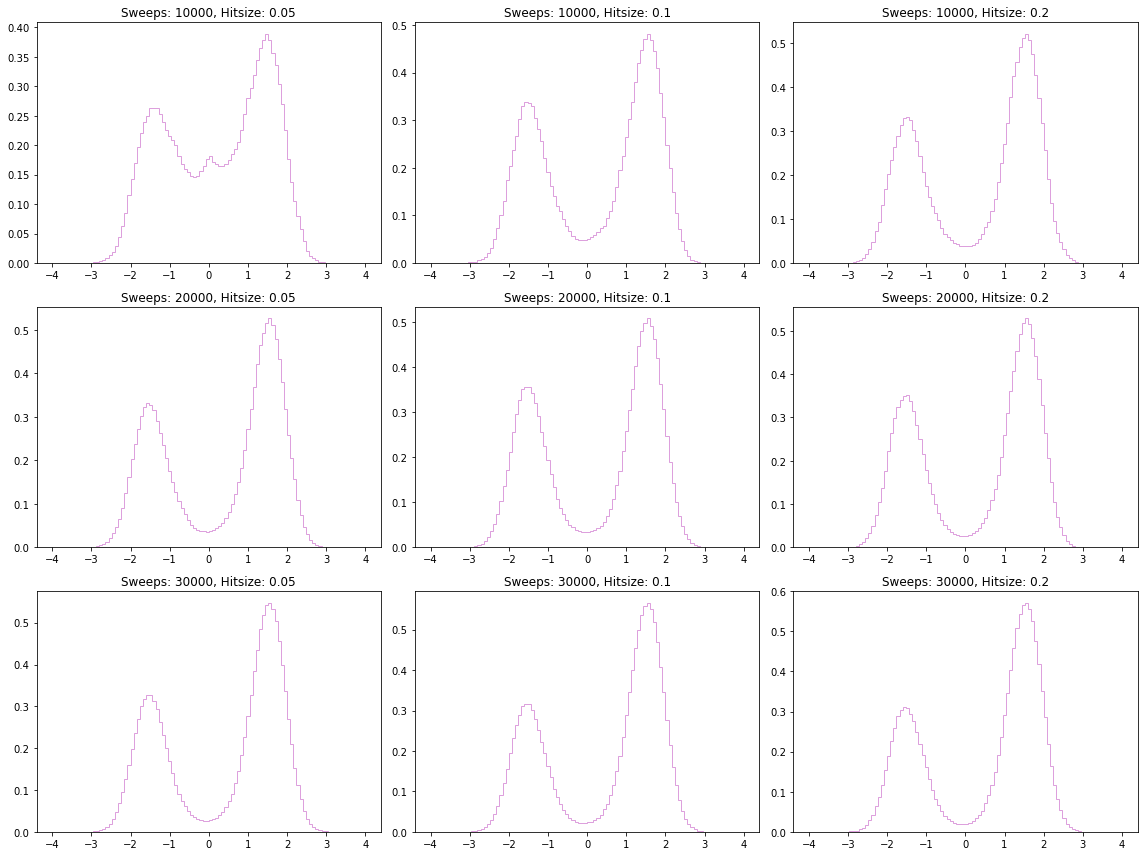

In [15]:
plot_prob_histograms(all_prob_histograms, sweep_values, hitsize_values)